In [1]:
import os
import pickle

import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # this is some Tensorflow magic I don't understand right now :D

In [3]:
IMG_WIDTH = 640
IMG_HEIGHT = 270
BATCH_SIZE = 32

In [4]:
# Load info about
train = pickle.load(open('../train.pickle', 'rb'))
speeds = tf.convert_to_tensor(train['targets'])

In [5]:
train.keys()

dict_keys(['image_paths', 'targets'])

In [6]:
# Split train into train and val
# train_paths = train['image_paths']

In [7]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.axis('off')

In [8]:
list_ds = tf.data.Dataset.list_files('../images/*.png')

In [9]:
def get_speed(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    img_number_str = tf.strings.split(parts[-1], '.')[0]
    img_number = tf.strings.to_number(img_number_str, out_type=tf.int32)
    return speeds[img_number]

In [10]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize img
    img = tf.image.resize(img, [IMG_HEIGHT//2, IMG_WIDTH//2])
    return img

In [11]:
def process_path(file_path):
    speed = get_speed(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, speed

In [12]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Speed:  21.673183


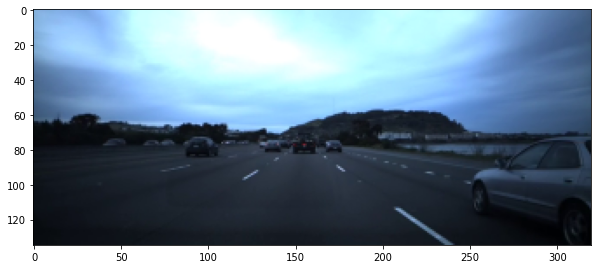

In [13]:
for image, label in labeled_ds.take(1):
    print("Speed: ", label.numpy())
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
plt.show()

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            print('yep')
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [15]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

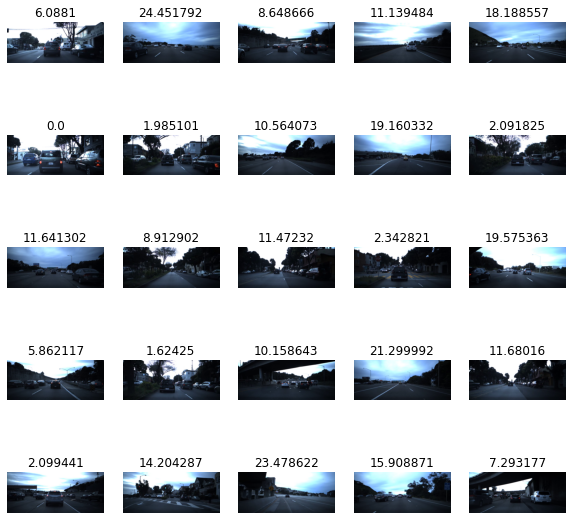

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
def get_model(params={}):
    return Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT//2, IMG_WIDTH//2, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(params.get('dropout_cnn_block_0', 0.3)),

        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(params.get('dropout_cnn_block_1', 0.3)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(params.get('dropout_cnn_block_2', 0.3)),

        Flatten(),

        Dense(1024, activation='relu'),
        Dropout(params.get('dropout_dense_block_0', 0.3)),

        Dense(512, activation='relu'),
        Dropout(params.get('dropout_dense_block_1', 0.3)),

        Dense(1, activation='relu')                    
    ])

In [18]:
model = get_model()
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 133, 318, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 131, 316, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 158, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 65, 158, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 156, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 154, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 77, 64)        0